In [1]:
import os ##冰激淋+擔擔麵+蜂蜜檸檬適用

os.environ["CUDA_VISIBLE_DEVICES"] = "0" #使用第0張顯卡 ##冰激淋+擔擔麵+蜂蜜檸檬適用 0or1

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.65
set_session(tf.Session(config=config))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Dropout, Flatten, Convolution1D, MaxPooling1D, Activation, BatchNormalization,\
Lambda, Concatenate, Add, Conv2D, Conv1D,TimeDistributed,MaxPooling2D
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from itertools import permutations
import matplotlib.pyplot as plt
import psutil
import os
import numpy as np
import pandas as pd
import datetime
import warnings
import pickle
import csv
import random
from keras.models import Sequential
from keras import backend as K

In [4]:

n=210527 #用2016 1~3月的資料 288x(31+29+31+30+31+30+...)=52416 210528-1(all) 差值在減一  
l=60 #288個一組 (24小時一組)
MLP_unit = 64
currencynum=5
currency = ["BTC","DASH","ETH","LTC","XMR"]
month = [0,31,60,91,121,152,182,213,244,274,305,335,366,397,425,456,486,517,547,578,609,639,670,700,731] #2016是閏年 366天
#month = [0,10,20,30,40,50]
month2 = [397,425,456,486,517,547,578,609,639,670,700,731] #2017 365天
#currency = ["BTC","DASH","ETH","LTC","JBY","GBP","EUR","AUD","US"]
question = ["trand","volatility"]
M=0

# 控制要不要存檔，1 : Yes, 0 : No
save = 1
epochs = 100
batch_size = 4096

all_cur_pair = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
if(M==0):
    all_cur_pair_P = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
elif(M==1):
    all_cur_pair_P = list(permutations(currency,2))# (Pn取2) 問題有先後順序時使用  
all_question= list(permutations(question,1))
np.set_printoptions(suppress=True)#不要用科學符號輸出
btc = 423.51
DASH = 0.00778 * btc
ETH = 0.0021652 * btc
LTC = 0.00805792 * btc
XMR = 0.00105001 * btc



In [5]:

"""
 V
"""
"""
diff
"""
df = pd.read_csv('btc_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
btc5months = np.zeros(n)
for i in range(n):
    btc5months[i] = df[0][i]
df = pd.read_csv('DASH_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
dash5months = np.zeros(n)
for i in range(n):
    dash5months[i] = df[0][i]
df = pd.read_csv('ETH_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
eth5months = np.zeros(n)
for i in range(n):
    eth5months[i] = df[0][i]
df = pd.read_csv('LTC_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
ltc5months = np.zeros(n)
for i in range(n):
    ltc5months[i] = df[0][i]
df = pd.read_csv('XMR_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
xmr5months = np.zeros(n)
for i in range(n):
    xmr5months[i] = df[0][i]    
print('finish dataread')
Train_data=np.zeros(((n-l+1,len(currency),l)))
for p in range(n-l+1):
    Train_data[p,0,:]=btc5months[p:p+l]
    Train_data[p,1,:]=dash5months[p:p+l]
    Train_data[p,2,:]=eth5months[p:p+l]
    Train_data[p,3,:]=ltc5months[p:p+l]
    Train_data[p,4,:]=xmr5months[p:p+l]

    

(210527, 1)
(210527, 1)
(210527, 1)
(210527, 1)
(210527, 1)
finish dataread


In [6]:

"""""""""
str, onehotcode, company code轉換
"""""""""


currencylist = {}
questionlist = {}
for i in range(len(currency)):
    currencylist[i] = currency[i]

for i in range(len(question)):
    questionlist[i] = question[i]

def str_to_currency(cur):
    return {v: k for k, v in currencylist.items()}[cur]

def str_to_question(q):
    return {v: k for k, v in questionlist.items()}[q]


def one_hot_currency(currencylist):
    d = {}
    temp = np.eye((len(currencylist)))
    for i in range(len(currencylist)):
        d[i] = temp[i]
    return d

def one_hot_question(questionlist):
    d = {}
    temp = np.eye((len(questionlist)))
    for i in range(len(questionlist)):
        d[i] = temp[i]
    return d

onehotcurrency = one_hot_currency(currencylist)
onehotquestion = one_hot_question(questionlist)


In [7]:

"""
Q&A
"""
vol='volatility'
def set_question(com1, com2, condition,typeq):
    # set condition
    def rise_of_fall():
        #目前問題設定只有三種設定：前者大(big)-0、後者大(small)-1、一樣(s)-2
        tmp = np.eye((2))
        d = {0:tmp[0],1:tmp[1]}
        return d
    # 拼接問題
    return np.concatenate((onehotquestion[str_to_question(typeq)],onehotcurrency[str_to_currency(com1)], onehotcurrency[str_to_currency(com2)], rise_of_fall()[condition]))

qtype = ['big','small']
HVqtype = ['big','small']


"""比漲幅程度類問題"""
def set_question_and_answer_pair(data, data2, n, all_cur_pair_P): #比較波動率大小的問題
    q_pair = {}
    a_pair = {}
    outcome=np.zeros((5,1))
    #data_sum=np.sum(data,axis=1)
    data2_sum=np.sum(data2,axis=1)
    outcome[0]=(data2_sum[0])/(btc + np.sum(btc5months[:n]))
    outcome[1]=(data2_sum[1])/(DASH + np.sum(dash5months[:n]))
    outcome[2]=(data2_sum[2])/(ETH + np.sum(eth5months[:n]))
    outcome[3]=(data2_sum[3])/(LTC + np.sum(ltc5months[:n]))
    outcome[4]=(data2_sum[4])/(XMR + np.sum(xmr5months[:n]))

    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(2):
        tmp_q = []
        tmp_a = []
            
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i, all_question[0][0]))
        q_pair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #同漲
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
     
        a_pair[i] = tmp_a
        
    return (data, q_pair, a_pair)


"""History Volatility類問題"""
def set_HVquestion_and_HVanswer_pair(data, data2,all_cur_pair_P): #比較波動率大小的問題
    q_HVpair = {}
    a_HVpair = {}
    outcome=np.zeros((5,1))
    #data_std=np.std(data,axis=1)
    data2_std=np.std(data2,axis=1)    
    outcome[0]=data2_std[0]
    outcome[1]=data2_std[1]
    outcome[2]=data2_std[2]
    outcome[3]=data2_std[3]
    outcome[4]=data2_std[4]
     
    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(2):
        tmp_q = []
        tmp_a = []
        
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i,all_question[1][0]))
        q_HVpair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #前者大
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
    
        a_HVpair[i] = tmp_a
        
    return (data, q_HVpair, a_HVpair)



In [8]:

"""
此處開始寫rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(m1*288,m3*288-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print(v.shape)
    v = v.reshape(len(v),5,l,1)
    print(v.shape)
    print("[Training model......]")
    
    #Train_v=v[:]
    
    Train_v=v[:((m2-m1)*288-72)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)*288-72)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)*288-72)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1)*288)*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1)*288)*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1)*288)*len(all_cur_pair_P)*len(qtype)*2:]
    history = model.fit([Train_v, Train_q], Train_a, validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    
    """
    算benchmark
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("benchacc:")
    print(benchacc)
    """
    畫圖
    """
    benchfunction=np.ones(a.shape[0])
    benchfunction=benchfunction*benchacc
    plt.plot(history.history['loss'], label='train')
    lastepoch_train_loss.append(history.history['loss'][-1])
    plt.plot(history.history['val_loss'], label='test')
    lastepoch_test_loss.append(history.history['val_loss'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['acc'], label='train')
    lastepoch_train_acc.append(history.history['acc'][-1])
    plt.plot(history.history['val_acc'], label='test')
    lastepoch_test_acc.append(history.history['val_acc'][-1])  
    plt.plot(np.arange(epochs),np.repeat(benchacc,epochs), label='benchmark')
    plt.xlabel("epoch") 
    plt.ylabel("acc") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    

In [9]:
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []


In [10]:

def ConvolutionNetworks(fn,ks):
    def conv(model):
        for i in range(len(fn)):
            model = (Conv2D(filters=fn[i],kernel_size=ks[i],padding='valid',activation='relu'))(model)  
            model = (MaxPooling2D(pool_size=(1,3)))(model)
            model = BatchNormalization()(model)
        return model
    return conv



def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y


def build_tag(conv):
    d = K.int_shape(conv)[1]
    d2 = K.int_shape(conv)[2]
    tag = np.zeros((d,d2,d+1))
    for i in range(d):
        for j in range(d2):
            tag[i,j,d] = float(int(i%d))/(d-1)*2-1
            tag[i,j,i] = 1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)




(None, 5, 4, 10)
(None, 5, 4, 6)
(None, 5, 4, 16)
g_MLP
drop_out
compile model success
12
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=3153 MiB, count=2, average=1577 MiB
(1377600, 60, 5)
(1377600, 5, 60, 1)
[Training model......]
Train on 1033920 samples, validate on 340800 samples
Epoch 1/100
1033920/1033920 [==============================] - 388s 375us/step - loss: 5.0036 - acc: 0.5261 - val_loss: 0.7671 - val_acc: 0.6429
Epoch 2/100
1033920/1033920 [==============================] - 76s 73us/step - loss: 0.8916 - acc: 0.5406 - val_loss: 0.6458 - val_acc: 0.6351
Epoch 3/100
1033920/1033920 [==============================] - 75s 73us/step - loss: 0.6702 - acc: 0.5772 - val_loss: 0.6217 - val_acc: 0.6440
Epoch 4/100
1033920/1033920 [==============================] - 75s 73us/step - loss: 0.6346 - acc: 0.6035 - val_loss: 0.5639 - val_acc: 0.6694
Epoch 5/100
1033920/1033920 [==============================] - 75s 73us/step - loss: 0.5892 - acc: 0.6304 - v

Epoch 56/100
1033920/1033920 [==============================] - 76s 73us/step - loss: 0.4325 - acc: 0.7194 - val_loss: 0.4927 - val_acc: 0.7189
Epoch 57/100
1033920/1033920 [==============================] - 76s 73us/step - loss: 0.4325 - acc: 0.7193 - val_loss: 0.4916 - val_acc: 0.7197
Epoch 58/100
1033920/1033920 [==============================] - 76s 73us/step - loss: 0.4316 - acc: 0.7202 - val_loss: 0.4882 - val_acc: 0.7200
Epoch 59/100
1033920/1033920 [==============================] - 76s 73us/step - loss: 0.4316 - acc: 0.7208 - val_loss: 0.4883 - val_acc: 0.7191
Epoch 60/100
1033920/1033920 [==============================] - 76s 73us/step - loss: 0.4309 - acc: 0.7217 - val_loss: 0.4884 - val_acc: 0.7217
Epoch 61/100
1033920/1033920 [==============================] - 76s 73us/step - loss: 0.4307 - acc: 0.7222 - val_loss: 0.4914 - val_acc: 0.7203
Epoch 62/100
1033920/1033920 [==============================] - 76s 73us/step - loss: 0.4302 - acc: 0.7224 - val_loss: 0.4895 - val_acc:

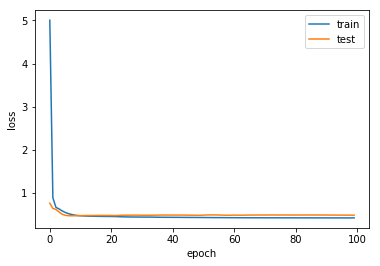

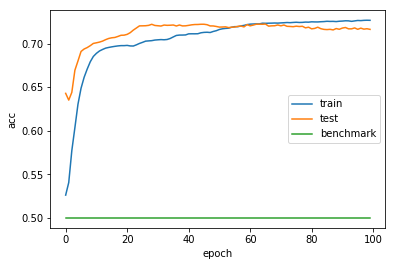

(None, 5, 4, 10)
(None, 5, 4, 6)
(None, 5, 4, 16)
g_MLP
drop_out
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=3153 MiB, count=884, average=3652 KiB
(1377600, 60, 5)
(1377600, 5, 60, 1)
[Training model......]
Train on 1022400 samples, validate on 352320 samples
Epoch 1/100
1022400/1022400 [==============================] - 429s 419us/step - loss: 6.0337 - acc: 0.5392 - val_loss: 4.4564 - val_acc: 0.5675
Epoch 2/100
1022400/1022400 [==============================] - 76s 74us/step - loss: 1.3410 - acc: 0.6042 - val_loss: 0.8934 - val_acc: 0.5894
Epoch 3/100
1022400/1022400 [==============================] - 75s 74us/step - loss: 0.6126 - acc: 0.6305 - val_loss: 0.8380 - val_acc: 0.6109
Epoch 4/100
1022400/1022400 [==============================] - 75s 74us/step - loss: 0.5614 - acc: 0.6490 - val_loss: 0.9988 - val_acc: 0.6249
Epoch 5/100
1022400/1022400 [==============================] - 75s 74us/step - loss: 0.5322 - acc: 0.6632 -

Epoch 56/100
1022400/1022400 [==============================] - 76s 74us/step - loss: 0.4261 - acc: 0.7195 - val_loss: 0.6351 - val_acc: 0.6737
Epoch 57/100
1022400/1022400 [==============================] - 76s 74us/step - loss: 0.4260 - acc: 0.7195 - val_loss: 0.6298 - val_acc: 0.6741
Epoch 58/100
1022400/1022400 [==============================] - 76s 74us/step - loss: 0.4259 - acc: 0.7191 - val_loss: 0.6220 - val_acc: 0.6750
Epoch 59/100
1022400/1022400 [==============================] - 76s 74us/step - loss: 0.4258 - acc: 0.7198 - val_loss: 0.6357 - val_acc: 0.6758
Epoch 60/100
1022400/1022400 [==============================] - 76s 74us/step - loss: 0.4258 - acc: 0.7194 - val_loss: 0.6181 - val_acc: 0.6759
Epoch 61/100
1022400/1022400 [==============================] - 76s 74us/step - loss: 0.4257 - acc: 0.7199 - val_loss: 0.6269 - val_acc: 0.6760
Epoch 62/100
1022400/1022400 [==============================] - 75s 74us/step - loss: 0.4253 - acc: 0.7193 - val_loss: 0.6116 - val_acc:

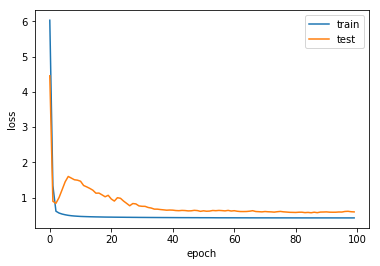

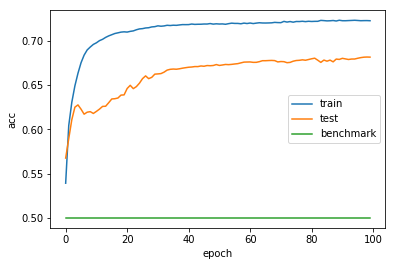

(None, 5, 4, 10)
(None, 5, 4, 6)
(None, 5, 4, 16)
g_MLP
drop_out
compile model success
14
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=3206 MiB, count=887, average=3701 KiB
(1400640, 60, 5)
(1400640, 5, 60, 1)
[Training model......]
Train on 1056960 samples, validate on 340800 samples
Epoch 1/100
1056960/1056960 [==============================] - 429s 406us/step - loss: 4.9132 - acc: 0.5296 - val_loss: 0.7193 - val_acc: 0.6266
Epoch 2/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.7890 - acc: 0.5793 - val_loss: 0.6351 - val_acc: 0.6316
Epoch 3/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.6333 - acc: 0.6087 - val_loss: 0.5954 - val_acc: 0.6490
Epoch 4/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.5957 - acc: 0.6305 - val_loss: 0.5603 - val_acc: 0.6581
Epoch 5/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.5665 - acc: 0.6469 -

Epoch 56/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4393 - acc: 0.7078 - val_loss: 0.4520 - val_acc: 0.6843
Epoch 57/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4393 - acc: 0.7080 - val_loss: 0.4517 - val_acc: 0.6842
Epoch 58/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4389 - acc: 0.7079 - val_loss: 0.4520 - val_acc: 0.6835
Epoch 59/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4389 - acc: 0.7081 - val_loss: 0.4529 - val_acc: 0.6838
Epoch 60/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4385 - acc: 0.7082 - val_loss: 0.4533 - val_acc: 0.6831
Epoch 61/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4386 - acc: 0.7085 - val_loss: 0.4541 - val_acc: 0.6816
Epoch 62/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4383 - acc: 0.7082 - val_loss: 0.4536 - val_acc:

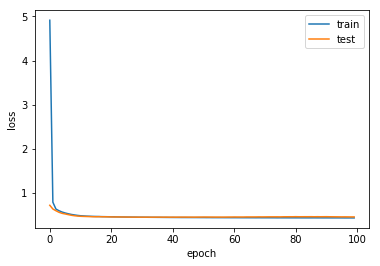

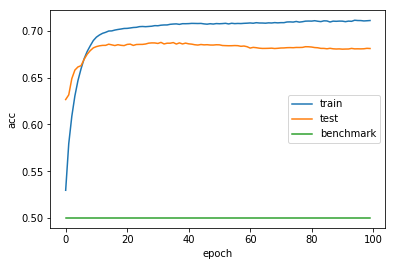

(None, 5, 4, 10)
(None, 5, 4, 6)
(None, 5, 4, 16)
g_MLP
drop_out
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=3206 MiB, count=889, average=3693 KiB
(1400640, 60, 5)
(1400640, 5, 60, 1)
[Training model......]
Train on 1045440 samples, validate on 352320 samples
Epoch 1/100
1045440/1045440 [==============================] - 408s 390us/step - loss: 4.5906 - acc: 0.5211 - val_loss: 0.7938 - val_acc: 0.6054
Epoch 2/100
1045440/1045440 [==============================] - 77s 73us/step - loss: 0.7403 - acc: 0.5765 - val_loss: 0.6237 - val_acc: 0.6429
Epoch 3/100
1045440/1045440 [==============================] - 76s 73us/step - loss: 0.6395 - acc: 0.6072 - val_loss: 0.5720 - val_acc: 0.6642
Epoch 4/100
1045440/1045440 [==============================] - 76s 73us/step - loss: 0.6053 - acc: 0.6312 - val_loss: 0.5383 - val_acc: 0.6737
Epoch 5/100
1045440/1045440 [==============================] - 77s 73us/step - loss: 0.5786 - acc: 0.6478 -

Epoch 56/100
1045440/1045440 [==============================] - 77s 74us/step - loss: 0.4382 - acc: 0.7029 - val_loss: 0.4277 - val_acc: 0.6965
Epoch 57/100
1045440/1045440 [==============================] - 77s 74us/step - loss: 0.4375 - acc: 0.7030 - val_loss: 0.4276 - val_acc: 0.6965
Epoch 58/100
1045440/1045440 [==============================] - 77s 74us/step - loss: 0.4373 - acc: 0.7026 - val_loss: 0.4273 - val_acc: 0.6965
Epoch 59/100
1045440/1045440 [==============================] - 77s 74us/step - loss: 0.4373 - acc: 0.7028 - val_loss: 0.4277 - val_acc: 0.6961
Epoch 60/100
1045440/1045440 [==============================] - 77s 74us/step - loss: 0.4369 - acc: 0.7027 - val_loss: 0.4278 - val_acc: 0.6961
Epoch 61/100
1045440/1045440 [==============================] - 77s 74us/step - loss: 0.4364 - acc: 0.7036 - val_loss: 0.4279 - val_acc: 0.6958
Epoch 62/100
1045440/1045440 [==============================] - 77s 73us/step - loss: 0.4369 - acc: 0.7036 - val_loss: 0.4281 - val_acc:

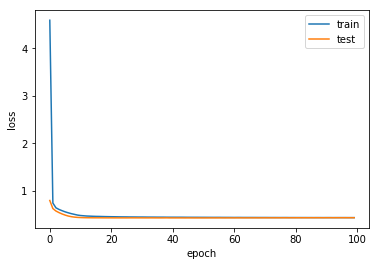

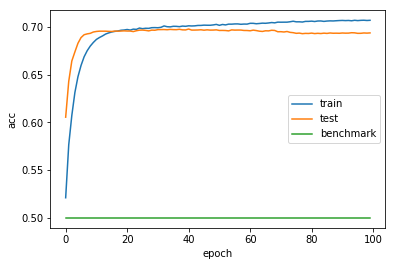

(None, 5, 4, 10)
(None, 5, 4, 6)
(None, 5, 4, 16)
g_MLP
drop_out
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=3232 MiB, count=889, average=3723 KiB
(1412160, 60, 5)
(1412160, 5, 60, 1)
[Training model......]
Train on 1056960 samples, validate on 352320 samples
Epoch 1/100
1056960/1056960 [==============================] - 386s 366us/step - loss: 5.8819 - acc: 0.5357 - val_loss: 2.3441 - val_acc: 0.6597
Epoch 2/100
1056960/1056960 [==============================] - 78s 74us/step - loss: 1.6189 - acc: 0.5917 - val_loss: 0.6601 - val_acc: 0.6502
Epoch 3/100
1056960/1056960 [==============================] - 78s 74us/step - loss: 0.6918 - acc: 0.6144 - val_loss: 0.5938 - val_acc: 0.6651
Epoch 4/100
1056960/1056960 [==============================] - 78s 74us/step - loss: 0.6023 - acc: 0.6399 - val_loss: 0.5503 - val_acc: 0.6761
Epoch 5/100
1056960/1056960 [==============================] - 78s 74us/step - loss: 0.5531 - acc: 0.6577 -

Epoch 56/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4313 - acc: 0.7010 - val_loss: 0.4741 - val_acc: 0.6868
Epoch 57/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4315 - acc: 0.7009 - val_loss: 0.4739 - val_acc: 0.6867
Epoch 58/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4310 - acc: 0.7009 - val_loss: 0.4747 - val_acc: 0.6865
Epoch 59/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4312 - acc: 0.7004 - val_loss: 0.4752 - val_acc: 0.6864
Epoch 60/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4311 - acc: 0.7019 - val_loss: 0.4729 - val_acc: 0.6866
Epoch 61/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4309 - acc: 0.7007 - val_loss: 0.4738 - val_acc: 0.6866
Epoch 62/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4309 - acc: 0.7012 - val_loss: 0.4742 - val_acc:

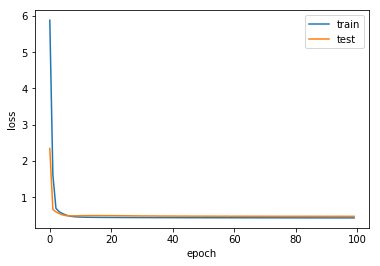

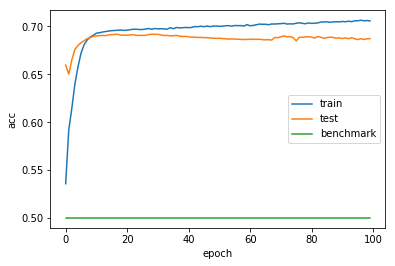

(None, 5, 4, 10)
(None, 5, 4, 6)
(None, 5, 4, 16)
g_MLP
drop_out
compile model success
17
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=3206 MiB, count=889, average=3693 KiB
(1400640, 60, 5)
(1400640, 5, 60, 1)
[Training model......]
Train on 1056960 samples, validate on 340800 samples
Epoch 1/100
1056960/1056960 [==============================] - 384s 363us/step - loss: 5.6020 - acc: 0.5287 - val_loss: 1.0820 - val_acc: 0.6502
Epoch 2/100
1056960/1056960 [==============================] - 78s 74us/step - loss: 1.1839 - acc: 0.5639 - val_loss: 0.6418 - val_acc: 0.6514
Epoch 3/100
1056960/1056960 [==============================] - 78s 73us/step - loss: 0.6826 - acc: 0.5874 - val_loss: 0.6025 - val_acc: 0.6743
Epoch 4/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.6283 - acc: 0.6119 - val_loss: 0.5601 - val_acc: 0.6854
Epoch 5/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.5887 - acc: 0.6316 -

Epoch 56/100
1056960/1056960 [==============================] - 76s 72us/step - loss: 0.4378 - acc: 0.6947 - val_loss: 0.4693 - val_acc: 0.6822
Epoch 57/100
1056960/1056960 [==============================] - 76s 72us/step - loss: 0.4376 - acc: 0.6946 - val_loss: 0.4680 - val_acc: 0.6851
Epoch 58/100
1056960/1056960 [==============================] - 76s 72us/step - loss: 0.4371 - acc: 0.6944 - val_loss: 0.4641 - val_acc: 0.6830
Epoch 59/100
1056960/1056960 [==============================] - 76s 72us/step - loss: 0.4363 - acc: 0.6967 - val_loss: 0.4667 - val_acc: 0.6812
Epoch 60/100
1056960/1056960 [==============================] - 76s 72us/step - loss: 0.4367 - acc: 0.6939 - val_loss: 0.4629 - val_acc: 0.6844
Epoch 61/100
1056960/1056960 [==============================] - 76s 72us/step - loss: 0.4364 - acc: 0.6962 - val_loss: 0.4658 - val_acc: 0.6845
Epoch 62/100
1056960/1056960 [==============================] - 76s 72us/step - loss: 0.4359 - acc: 0.6942 - val_loss: 0.4623 - val_acc:

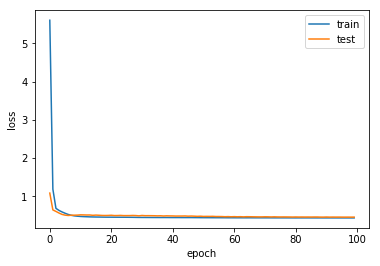

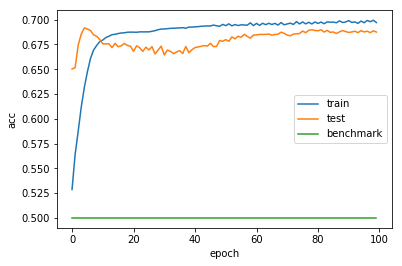

(None, 5, 4, 10)
(None, 5, 4, 6)
(None, 5, 4, 16)
g_MLP
drop_out
compile model success
18
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=3232 MiB, count=889, average=3723 KiB
(1412160, 60, 5)
(1412160, 5, 60, 1)
[Training model......]
Train on 1056960 samples, validate on 352320 samples
Epoch 1/100
1056960/1056960 [==============================] - 386s 365us/step - loss: 7.0203 - acc: 0.5252 - val_loss: 4.0512 - val_acc: 0.6804
Epoch 2/100
1056960/1056960 [==============================] - 76s 72us/step - loss: 4.4022 - acc: 0.6257 - val_loss: 1.9902 - val_acc: 0.7052
Epoch 3/100
1056960/1056960 [==============================] - 78s 74us/step - loss: 1.0580 - acc: 0.6156 - val_loss: 0.5465 - val_acc: 0.6961
Epoch 4/100
1056960/1056960 [==============================] - 78s 74us/step - loss: 0.6014 - acc: 0.6498 - val_loss: 0.4952 - val_acc: 0.7066
Epoch 5/100
1056960/1056960 [==============================] - 78s 74us/step - loss: 0.5534 - acc: 0.6673 -

Epoch 56/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4328 - acc: 0.7009 - val_loss: 0.3947 - val_acc: 0.7421
Epoch 57/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4324 - acc: 0.7019 - val_loss: 0.3973 - val_acc: 0.7409
Epoch 58/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4323 - acc: 0.7019 - val_loss: 0.3945 - val_acc: 0.7423
Epoch 59/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4322 - acc: 0.7015 - val_loss: 0.3935 - val_acc: 0.7426
Epoch 60/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4313 - acc: 0.7017 - val_loss: 0.3990 - val_acc: 0.7397
Epoch 61/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4322 - acc: 0.7015 - val_loss: 0.3938 - val_acc: 0.7422
Epoch 62/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4325 - acc: 0.7013 - val_loss: 0.3931 - val_acc:

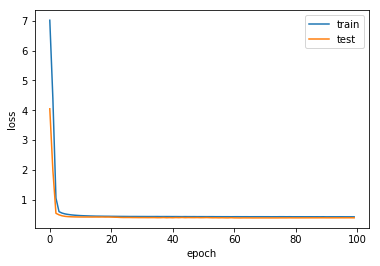

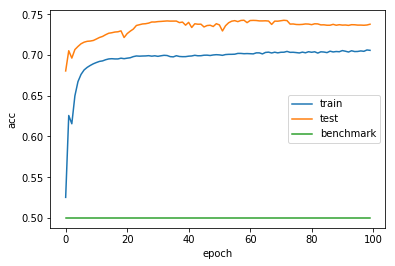

(None, 5, 4, 10)
(None, 5, 4, 6)
(None, 5, 4, 16)
g_MLP
drop_out
compile model success
19
<ipython-input-8-4a0cac6ebd95>:49: size=3232 MiB, count=2, average=1616 MiB
(1400640, 60, 5)
(1400640, 5, 60, 1)
[Training model......]
Train on 1056960 samples, validate on 340800 samples
Epoch 1/100
1056960/1056960 [==============================] - 388s 367us/step - loss: 5.0611 - acc: 0.5498 - val_loss: 1.6183 - val_acc: 0.6342
Epoch 2/100
1056960/1056960 [==============================] - 78s 74us/step - loss: 1.1187 - acc: 0.6142 - val_loss: 0.8006 - val_acc: 0.6533
Epoch 3/100
1056960/1056960 [==============================] - 78s 73us/step - loss: 0.6126 - acc: 0.6428 - val_loss: 0.6685 - val_acc: 0.6787
Epoch 4/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.5454 - acc: 0.6696 - val_loss: 0.5916 - val_acc: 0.6886
Epoch 5/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.5048 - acc: 0.6860 - val_loss: 0.5485 - val_acc: 0.6943
Epoc

1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4111 - acc: 0.7222 - val_loss: 0.4145 - val_acc: 0.7325
Epoch 57/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4110 - acc: 0.7224 - val_loss: 0.4175 - val_acc: 0.7320
Epoch 58/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4114 - acc: 0.7221 - val_loss: 0.4152 - val_acc: 0.7321
Epoch 59/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4110 - acc: 0.7225 - val_loss: 0.4092 - val_acc: 0.7334
Epoch 60/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4109 - acc: 0.7223 - val_loss: 0.4172 - val_acc: 0.7320
Epoch 61/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4109 - acc: 0.7222 - val_loss: 0.4114 - val_acc: 0.7329
Epoch 62/100
1056960/1056960 [==============================] - 77s 73us/step - loss: 0.4109 - acc: 0.7222 - val_loss: 0.4206 - val_acc: 0.7315
Epoch

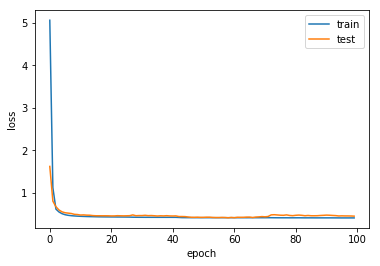

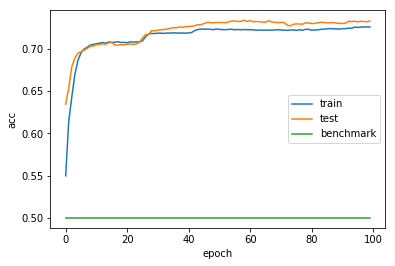

In [11]:

#model.summary()

for i in range(12,20,1):

    MLP_unit=64
    visual_scene = Input((currencynum,l,1))
    visual_conv = ConvolutionNetworks([20,10],[(1,5),(1,5)])(visual_scene)
    print(K.int_shape(visual_conv))
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([tag, visual_conv])
    print(K.int_shape(visual_conv))
    
    shapes = visual_conv.shape
    w = shapes[1]
    f = shapes[2]
    features= []
    #features = np.zeros(0)
    for k1 in range(w):
        for k2 in range(f):
            def get_feature(t):
                return t[:, k1, k2, :]
            #get_feature_layer = Lambda(get_feature)
            features.append(Lambda(get_feature)(visual_conv))
    
      
    input2 = Input((14,))
    onehot_encode_question = input2
    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode_question]))    
    
     
    g_MLP = get_MLP(4, get_dense(4,MLP_unit))
    
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))
    
    combined_relation = Add()(mid_relations)
    
    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')
    
    pred = Dense(1, activation = 'sigmoid')(rn)
    
    
    #model = Model(inputs=[visual_scene])
    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(i)
    fit_show(Train_data,month[i],month[i+3],month[i+4])
    

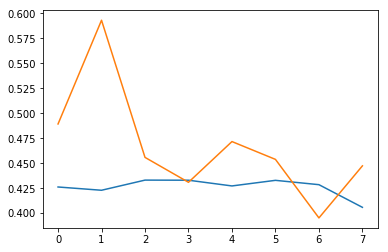

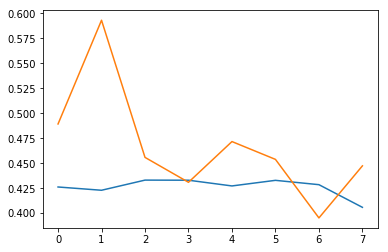

In [12]:
    
plt.plot(lastepoch_train_acc)
plt.plot(lastepoch_test_acc)
plt.show()
plt.plot(lastepoch_train_loss)
plt.plot(lastepoch_test_loss)
plt.show()

In [13]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 5, 60, 1)     0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 5, 56, 20)    120         input_22[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 5, 18, 20)    0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 5, 18, 20)    80          max_pooling2d_15[0][0]           
__________________________________________________________________________________________________
conv2d_16 

dense_52 (Dense)                (None, 64)           4160        dense_51[0][0]                   
                                                                 dense_51[1][0]                   
                                                                 dense_51[2][0]                   
                                                                 dense_51[3][0]                   
                                                                 dense_51[4][0]                   
                                                                 dense_51[5][0]                   
                                                                 dense_51[6][0]                   
                                                                 dense_51[7][0]                   
                                                                 dense_51[8][0]                   
                                                                 dense_51[9][0]                   
          